#### Mahri


In [4]:
# On g collab only
!git clone https://github.com/electronjia/heart_cardiac_mri_image_processing.git

Cloning into 'heart_cardiac_mri_image_processing'...
remote: Enumerating objects: 13053, done.
remote: Counting objects: 100% (815/815), done.
remote: Compressing objects: 100% (486/486), done.
remote: Total 13053 (delta 343), reused 764 (delta 329), pack-reused 12238 (from 2)
Receiving objects: 100% (13053/13053), 711.16 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (929/929), done.
Updating files: 100% (11126/11126), done.


In [5]:
# On g collab only
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.5 MB/s eta 0:00:00


In [6]:
# On g collab only
!pwd
!ls -l
%cd heart_cardiac_mri_image_processing/edge_detection_and_contours
!pwd

/content
total 8
drwxr-xr-x 6 root root 4096 Mar 23 15:42 heart_cardiac_mri_image_processing
drwxr-xr-x 1 root root 4096 Mar 20 13:31 sample_data
/content/heart_cardiac_mri_image_processing/edge_detection_and_contours
/content/heart_cardiac_mri_image_processing/edge_detection_and_contours


In [44]:
import pandas as pd
from config import *
import os
import numpy as np
from skimage import exposure, filters, measure, morphology
import matplotlib.pyplot as plt
import pydicom
from skimage import img_as_ubyte
from skimage.feature import canny
from skimage.measure import label, regionprops
import ipywidgets as widgets
from IPython.display import display
from skimage.draw import polygon, disk
from skimage.morphology import convex_hull_image


In [8]:
# On g collab only
import sys
sys.path.append('/content/heart_cardiac_mri_image_processing/edge_detection_and_contours')
user_handle = r"/content/heart_cardiac_mri_image_processing/data"
patient_data_excel_path = r"/content/heart_cardiac_mri_image_processing/scd_patientdata_xlsx.xlsx"
patient_data = "patient_data"
patient_filepaths = "patient_filepaths"

user_handle_g_collab = "/content/heart_cardiac_mri_image_processing/data"

In [9]:
# # Number of columns for plotting
# num_cols = 10

# # Patient index
# patient_idx = 1

# patient_thresholds = {
#     'eccentricity': [0.8, 0.8, 0.8, 0.8, 0.8],
#     'area': [300, 400, 400, 400, 400],
#     'seed_starter' : [(90, 120), (80,130), (90, 120), (90, 120), (90, 120)],
#     'disk_size': [1,1,1,1,1],
#     'sigma_gaus': [0.2,0.2,0.2,0.2,0.2],
#     'clip_limit': [0.03,0.05,0.03,0.03,0.03],
#     'sigma_edge': [7.00,5.0,6.00,5.00,6.00],
#     'level': [0.7,0.7,0.7,0.7,0.7]
#     # 'distance_centroid':
# }

# patient_mask_info = []

In [10]:
patient_xlsx = patient_data_excel_path
patient_data_df = pd.read_excel(patient_xlsx, sheet_name=patient_data)
patient_filepaths_df = pd.read_excel(patient_xlsx, sheet_name=patient_filepaths)
patient_mask_filepaths = pd.read_excel(patient_xlsx, sheet_name="mask_filepaths")

display(patient_data_df.head(2))
display(patient_filepaths_df.head(2))

,patient_id,original_id,gender,age,pathology,filepath,gif_filepath
0,SCD0000101,SC-HF-I-1,Male,53,Heart failure with infarct,SCD_IMAGES_01\SCD0000101\CINESAX_300,SCD_IMAGES_01\SCD0000101\SCD0000101_gif.gif
1,SCD0000201,SC-HF-I-2,Male,48,Heart failure with infarct,SCD_IMAGES_01\SCD0000201\CINESAX_300,SCD_IMAGES_01\SCD0000201\SCD0000201_gif.gif


,patient_id,dcm_image_filepath
0,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...
1,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...


In [14]:
# # Single patient
# patient_ids = patient_filepaths_df['patient_id'].unique()
# patient_id = patient_ids[patient_idx]
# single_patient_filepaths = patient_filepaths_df.loc[patient_filepaths_df['patient_id'] == patient_id, 'dcm_image_filepath'].tolist()


In [61]:
def read_convert_dicom_img(filepath):
    # Read the DICOM image
    dicom_img = pydicom.dcmread(filepath)

    # Extract the pixel data and convert to 8-bit image
    img = img_as_ubyte(dicom_img.pixel_array / np.max(dicom_img.pixel_array))
    return img

In [62]:
# def apply_contrast_enhancement(img, clip_limit, obj_center, region_size=100):

#     rows, cols = img.shape
#     center_row, center_col = obj_center

#      # Define region of interest
#     r_min = max(0, center_row - region_size // 2)
#     r_max = min(rows, center_row + region_size // 2)
#     c_min = max(0, center_col - region_size // 2)
#     c_max = min(cols, center_col + region_size // 2)

#     # Apply CLAHE only to the region
#     img_roi = img[r_min:r_max, c_min:c_max]
#     img_roi_enhanced = exposure.equalize_adapthist(img_roi, clip_limit=clip_limit)

#     # Create a copy of the original image to insert enhanced region
#     blended_img = img.copy()
#     blended_img[r_min:r_max, c_min:c_max] = img_roi_enhanced  # Paste enhanced region back

#     return blended_img



def apply_contrast_enhancement(img, clip_limit):
    # Apply contrast
    img_contrast = exposure.equalize_adapthist(img, clip_limit=clip_limit)

    # Create radial mask for center contrast enhancement
    # Create a grid of distances from the center
    rows, cols = img_contrast.shape
    center_row, center_col = rows//2, cols//2

    # Create radial distance map
    y, x = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - center_col)**2 + (y - center_row)**2)

    # Normalize distance to range [0, 1]
    distance_from_center = distance_from_center / np.max(distance_from_center)

    # Apply the mask (higher values in the center)
    radial_mask = 1 - distance_from_center  # Invert to get higher values at the center
    enhanced_contrast_img = img_contrast * radial_mask

    return enhanced_contrast_img




# import numpy as np
# from skimage import exposure, filters
# import cv2

# def apply_contrast_enhancement(img, clip_limit, lv_center, focus_radius=50):
#     """
#     Enhances contrast around the left ventricle using CLAHE and a radial mask.

#     Parameters:
#     - img: Grayscale image (2D numpy array).
#     - clip_limit: CLAHE clip limit.
#     - lv_center: Tuple (row, col) indicating the left ventricle center.
#     - focus_radius: Radius of the area around the LV for enhanced contrast.

#     Returns:
#     - Enhanced contrast image with focus on LV edges.
#     """

#     # Apply CLAHE for global contrast enhancement
#     img_clahe = exposure.equalize_adapthist(img, clip_limit=clip_limit)

#     # Apply edge-preserving filter (optional)
#     img_filtered = cv2.bilateralFilter(img_clahe.astype(np.float32), 9, 75, 75)

#     # Create radial mask emphasizing LV region
#     rows, cols = img.shape
#     y, x = np.ogrid[:rows, :cols]
#     mask = np.sqrt((x - lv_center[1])**2 + (y - lv_center[0])**2)
#     mask = 1 - np.clip(mask / focus_radius, 0, 1)  # Normalize mask (center = 1, edges = 0)

#     # Apply mask to focus contrast enhancement near the LV
#     enhanced_img = img_filtered * mask + img * (1 - mask)

#     # Sharpen edges to enhance boundaries
#     edges = filters.sobel(enhanced_img)  # Extract edges using Sobel filter
#     enhanced_img += edges * 0.5  # Blend edges back for more definition

#     return enhanced_img


In [17]:
def detect_edges_and_contours(img, sigma, level):
    # Edge detection
    img_edges = canny(img, sigma=sigma)

    # Find and draw contours
    contours = measure.find_contours(img_edges, level=level)

    # Create a binary mask with contours
    binary_mask = np.zeros_like(img, dtype=np.uint8)
    for contour in contours:
        # Convert contour to polygon coordinates and fill it in the binary image
        contour_points = contour.astype(int)
        rr, cc = polygon(contour_points[:, 0], contour_points[:, 1], shape=binary_mask.shape)
        binary_mask[rr, cc] = 255  # Set contour area to foreground (255)

    return img_edges, contours, binary_mask

In [18]:
def get_labels_regions(binary_mask):
    # Find the labels in binary mask
    labeled_img, _ = measure.label(binary_mask, connectivity=2, return_num=True)

    # Measure region properties
    regions = measure.regionprops(labeled_img)

    return labeled_img, regions

In [83]:
def segment_left_ventricle(filepath, labeled_img, regions, mask_info_dict, img_idx, seed_starter, eccentricity_th, area_th, distance_th):

  # Find best region depending on previous best region or
  min_distance = float('inf')
  best_region = None

  # Attempt to get the best region by comparing to previous region if exists, if not, use seed starter
  for prop in regions:
      # Compare the centroid from the dictionary if it exists
      # if mask_info_dict['centroid_coords']:
      #     previous_centroid = np.array(mask_info_dict['centroid_coords'][img_idx-1])
      #     current_centroid = np.array(prop.centroid)
      #     distance = np.linalg.norm(current_centroid - previous_centroid)  # Euclidean distance

      #     if distance < min_distance:
      #         min_distance = distance
      #         best_region = prop
      # else:
      #   # Use the set seed starter
      previous_centroid = np.array(seed_starter)
      current_centroid = np.array(prop.centroid)
      distance = np.linalg.norm(current_centroid - previous_centroid)  # Euclidean distance

      if distance < min_distance:
        # print(min_distance)
        min_distance = distance
        best_region = prop


  # Attempt to evaluate the best region's eccentricity and area according to set thresholds
  try:
    if best_region.eccentricity < eccentricity_th and best_region.area < area_th and min_distance < distance_th:
      filled_mask = get_convex_hull_mask(labeled_img, best_region)

    else:
      # best_region = None
      # min_distance = float('inf')
      # for prop in regions:

      #   previous_centroid = np.array(seed_starter)
      #   current_centroid = np.array(prop.centroid)
      #   distance = np.linalg.norm(current_centroid - previous_centroid)  # Euclidean distance

      #   if distance < min_distance:
      #       min_distance = distance
      #       best_region = prop

      # if best_region.eccentricity > eccentricity_th or best_region.area > area_th:
      filled_mask = 0

      # else:
      #   filled_mask = get_convex_hull_mask(labeled_img, best_region)


    # Append the dictionary info
    mask_info_dict["index"].append(img_idx)
    mask_info_dict["frames"].append(filepath)
    mask_info_dict["eccentricity"].append(best_region.eccentricity)
    mask_info_dict["area"].append(best_region.area)
    mask_info_dict["coords"].append(best_region.coords)
    mask_info_dict["centroid_coords"].append(best_region.centroid)
    mask_info_dict["distance_centroid"].append(min_distance)
    mask_info_dict['mask'].append(filled_mask)

  except:
    filled_mask = 0
    # Append the dictionary info
    mask_info_dict["index"].append(img_idx)
    mask_info_dict["frames"].append(filepath)
    mask_info_dict["eccentricity"].append(0)
    mask_info_dict["area"].append(0)
    mask_info_dict["coords"].append(0)
    mask_info_dict["centroid_coords"].append((0,0))
    mask_info_dict["distance_centroid"].append(0)
    mask_info_dict['mask'].append(filled_mask)


  return filled_mask, mask_info_dict

In [71]:
def get_convex_hull_mask(labeled_img, region):

    # Create a mask for smallest eccentricity region
    binary_mask = np.zeros_like(labeled_img, dtype=np.uint8)
    binary_mask[labeled_img == region.label] = 255

    # Generate convex hull mask
    hull_mask = convex_hull_image(binary_mask)

    # Find contours in the binary mask
    contours = measure.find_contours(hull_mask, level=0.5)

    # Obtain the filled mask
    filled_mask = np.zeros_like(binary_mask, dtype=np.uint8)

    # Loop through each contour and fill it in the mask
    for contour in contours:
        # Convert contour coordinates to integer values
        contour_points = contour.astype(int)

        # Get the coordinates of the contour and fill the polygon
        rr, cc = polygon(contour_points[:, 0], contour_points[:, 1], shape=filled_mask.shape)

        # Set the region inside the polygon to 255 (foreground)
        filled_mask[rr, cc] = 255  # Set filled region to white (255)

    return filled_mask



# def get_convex_hull_mask(labeled_img, region):
#     """
#     Generate a circular mask that fits the segmented region instead of using a convex hull.

#     Parameters:
#     - labeled_img: Labeled image where each region has a unique integer label.
#     - region: The specific region from skimage.measure.regionprops.

#     Returns:
#     - filled_mask: A binary mask with a fitted circle around the region.
#     """

#     # Create an empty mask
#     binary_mask = np.zeros_like(labeled_img, dtype=np.uint8)
#     binary_mask[labeled_img == region.label] = 255  # Mark the region

#     # Get the coordinates of the pixels in the region
#     coords = np.column_stack(np.where(binary_mask > 0))

#     # Compute the centroid
#     center_y, center_x = np.mean(coords, axis=0)

#     # Compute the maximum distance from the centroid (fitting the enclosing circle)
#     max_radius = np.max(np.linalg.norm(coords - [center_y, center_x], axis=1))

#     # Create an empty mask
#     filled_mask = np.zeros_like(binary_mask, dtype=np.uint8)

#     # Draw the circle on the mask
#     rr, cc = disk((center_y, center_x), max_radius, shape=filled_mask.shape)
#     filled_mask[rr, cc] = 255  # Set the circular region to white (255)

#     return filled_mask


Processing patient: SCD0001601 with index of 15


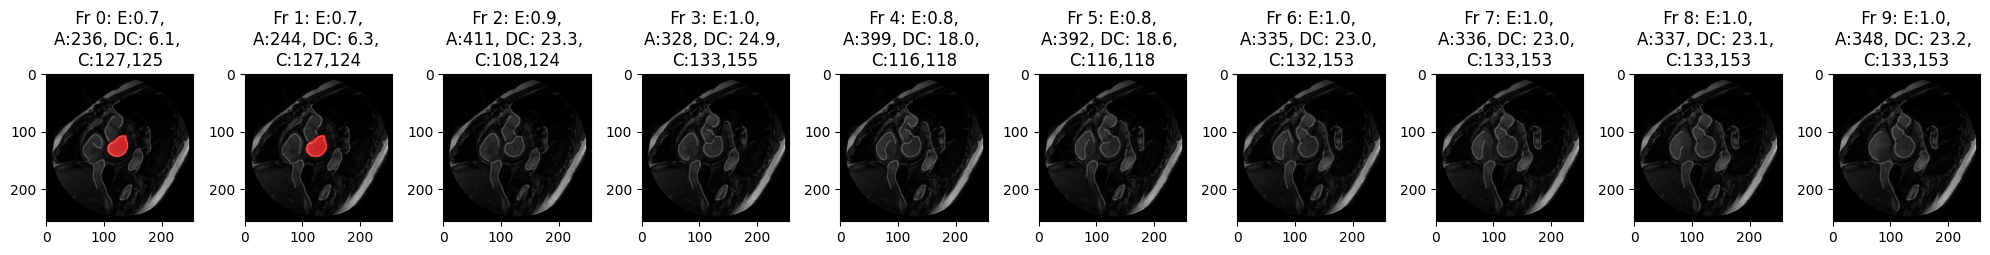

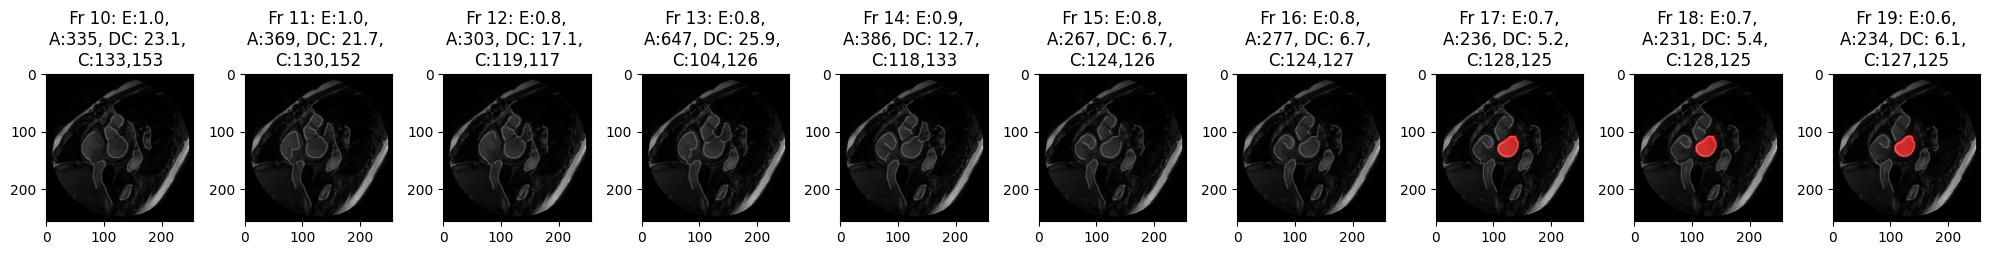

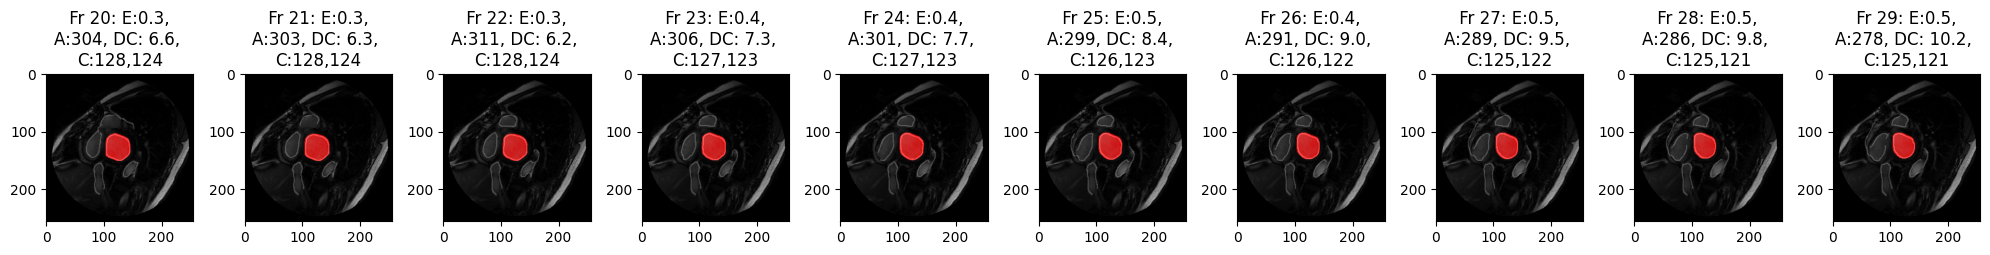

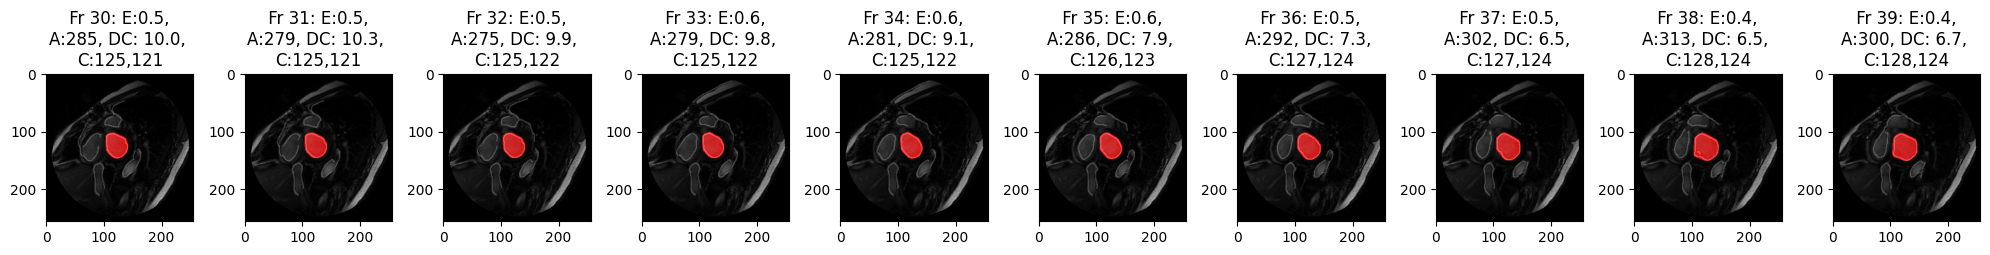

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-168-1eda964c93f9>", line 87, in <cell line: 0>
    plt.show()
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
           ^^^^^^^^^^^^^^
  File "<decorator-ge

In [ ]:
# Number of columns for plotting
num_cols = 10

# Patient index: patient 2,4,6,7,8,14 is perfect example to show, worst examples are patient 1,3

# Single patient
# patient_id = patient_ids[patient_idx]
# patient_idx = 15

patient_thresholds = {
    'eccentricity': [0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
    'area': [300, 400, 400, 400, 400, 400, 400, 500, 500, 400, 300, 400, 400, 400, 400, 400, 400, 400, 400, 400],
    'seed_starter' : [(130, 130), (130,130), (130, 130), (120, 120), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (130, 130), (120, 120), (120, 120), (120, 120), (120, 120)],
    'disk_size': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    # Decrese sigma gaus to make it less smooth and more pronounced
    'sigma_gaus': [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05],
    'clip_limit': [0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03],
    # Increase sigma edge to get rid of some unwanted edges
    'sigma_edge': [6.30,6.3,6.30,5.00,6.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,6.00,6.00,5.00,5.00,5.00,5.00,],
    'level': [0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7],
    'distance_centroid_th': [20,20,20,20,20,20,20,20,20,30,20,20,20,20,20,20,20,20,20,20],
}

patient_mask_info = []

patient_ids = patient_filepaths_df['patient_id'].unique()

for patient_idx, patient_id in enumerate(patient_ids[15:]):
  single_patient_filepaths = patient_filepaths_df.loc[patient_filepaths_df['patient_id'] == patient_id, 'dcm_image_filepath'].tolist()


  print(f"Processing patient: {patient_id} with index of {patient_idx}")

  img_processing_params = {key: value[patient_idx] for key,value in patient_thresholds.items()}

  mask_info_dict = {
      "index": [],
      "frames": [],
      "eccentricity": [],
      "area": [],
      "coords": [],
      "centroid_coords": [],
      "distance_centroid": [],
      "mask": []
  }
  for batch_idx, batch_start in enumerate(range(0, len(single_patient_filepaths), num_cols)):

      batch_filepaths = single_patient_filepaths[batch_start:batch_start + num_cols]

      num_imgs = len(batch_filepaths)
      fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * 2, 5))

      if num_imgs == 1:
          axes = [axes]  # Ensure axes is iterable when there's only one image

      # Iterate over the filepaths in given batch
      for batch_img_idx, img_filepath in enumerate(batch_filepaths):

          # Get the original image index
          img_idx = int(f"{batch_idx}{batch_img_idx}")

          # For Google Colab only
          img_filepath = img_filepath.replace("\\", "/")
          img_abs_filepath = os.path.join(user_handle_g_collab, img_filepath)

          # Get the 8 bit image
          img_8bit = read_convert_dicom_img(img_abs_filepath)

          # Get filtered image
          img_filt = filters.gaussian(img_8bit, sigma=img_processing_params['sigma_gaus'])

          # Apply radial contrast on image
          img_contrast = apply_contrast_enhancement(img_filt, img_processing_params['clip_limit'])

          # Get edges, contours, and binary mask
          img_edges, contours, binary_mask = detect_edges_and_contours(img_contrast, sigma=img_processing_params['sigma_edge'], level=img_processing_params['level'])

          # Get labeled image and regions
          labeled_img, regions = get_labels_regions(binary_mask)
          # print(regions)

          # Get the filled mask where left ventricle is defined
          filled_mask, mask_info_dict = segment_left_ventricle(filepath=img_abs_filepath, labeled_img=labeled_img, regions=regions, mask_info_dict=mask_info_dict, img_idx=img_idx, seed_starter=img_processing_params['seed_starter'], eccentricity_th = img_processing_params['eccentricity'], area_th=img_processing_params['area'], distance_th=img_processing_params['distance_centroid_th'])

          # Plot the overlay
          # Normalize original image for proper display (optional)
          img_plot = (img_8bit - img_8bit.min()) / (img_8bit.max() - img_8bit.min())  # Normalize to [0,1] range

          # Create an RGB version of the grayscale image
          img_rgb = np.stack([img_plot] * 3, axis=-1)  # Convert grayscale to RGB (shape: HxWx3)

          # Create a red-colored mask (overlay will be red where the mask is)
          mask_rgb = np.zeros_like(img_rgb)  # Create an empty RGB image

          mask_rgb[:, :, 0] = filled_mask  # Red channel

          # Alpha blending
          alpha = 0.05  # Transparency level
          overlay = (img_rgb * (1 - alpha) + mask_rgb * alpha)

          # Ensure values are in valid range [0,1] for display
          overlay = np.clip(overlay, 0, 1)

          # Plot processed image
          centroid_plot = f"C:{mask_info_dict['centroid_coords'][img_idx][0]:.0f},{mask_info_dict['centroid_coords'][img_idx][1]:.0f}"
          # axes[batch_img_idx].imshow(img_contrast, cmap="gray", vmin=np.min(img_contrast), vmax=np.max(img_contrast))
          # axes[batch_img_idx].imshow(binary_mask, cmap="gray", vmin=np.min(binary_mask), vmax=np.max(binary_mask), alpha=0.5)
          axes[batch_img_idx].set(title=f" Fr {img_idx}: E:{mask_info_dict['eccentricity'][img_idx]:.1f}, \nA:{mask_info_dict['area'][img_idx]:.0f}, C:{centroid_plot}")

          # Plot final segmentation result
          axes[batch_img_idx].imshow(overlay, cmap="gray", vmin=np.min(overlay), vmax=np.max(overlay))
          axes[batch_img_idx].imshow(binary_mask, cmap="gray", vmin=np.min(binary_mask), vmax=np.max(binary_mask), alpha=0.2)
          axes[batch_img_idx].set(title=f" Fr {img_idx}: E:{mask_info_dict['eccentricity'][img_idx]:.1f}, \nA:{mask_info_dict['area'][img_idx]:.0f}, DC: {mask_info_dict['distance_centroid'][img_idx]:.1f}, \n{centroid_plot}")

      plt.tight_layout()
      plt.show()
  patient_mask_info.append(mask_info_dict)


